
Imports

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
df_test = pd.read_csv("Data\Battery_Testing_Data.csv") # may need to change the path
df_soc = pd.read_csv("Data\SOC_OCV_MFCTT_2019.csv",sep="\t")


In [78]:
df_test.head()

,Time (s),Current (mA),Voltage (V),Temperature
0,NaN,NaN,NaN,NaN
1,1.0,0.0,4.05,21.96
2,2.0,0.0,4.05,21.94
3,3.0,0.0,4.05,21.94
4,4.0,0.0,4.05,21.93


In [79]:
df_soc.head()

,SOC,Ecell/V
0,100.000000,4.186240
1,99.998926,4.186390
2,99.997852,4.186268
3,99.996778,4.186108
4,99.995704,4.186100


In [80]:
df_soc.columns = ["SOC","OCV"]
df_test.columns = ["Time","Current","Voltage","Temperature"]
df_test.loc[:,"Current"] = df_test.loc[:,"Current"]/1000 # convert to A

Make some plots

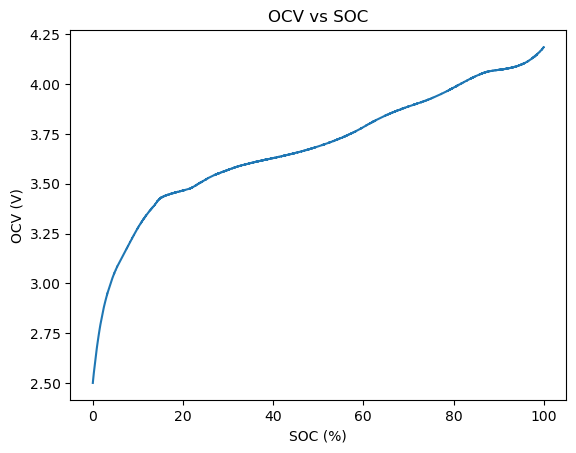

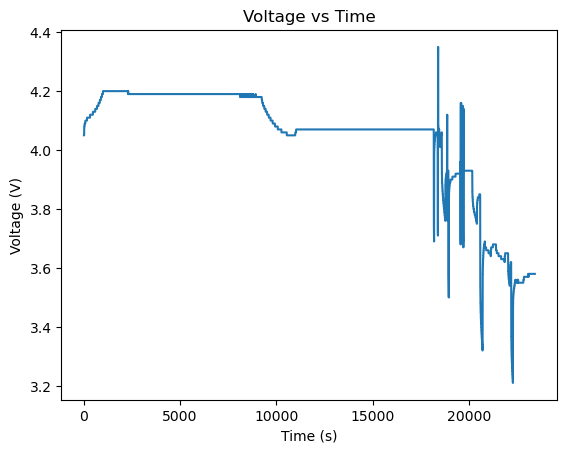

In [81]:
plt.plot(df_soc['SOC'],df_soc['OCV'])
plt.xlabel("SOC (%)")
plt.ylabel("OCV (V)")
plt.title("OCV vs SOC")
plt.show()

plt.plot(df_test.Time,df_test.Voltage)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Voltage vs Time")
plt.show()

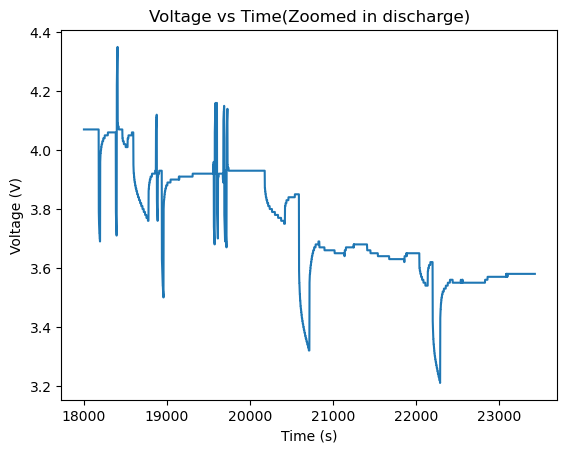

In [82]:
plt.plot(df_test.Time[18000:],df_test.Voltage[18000:])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Voltage vs Time(Zoomed in discharge)")
plt.show()

Predict SOC usign Coluomb Counting

In [87]:
D = np.array(2)
D = np.append(D,3)
D

array([2, 3])

In [88]:
Z = np.ndarray(df_test.shape[0]) 
Z[0] = 0.86

array([1.24775988e-311, 1.24878508e-311, 0.00000000e+000, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

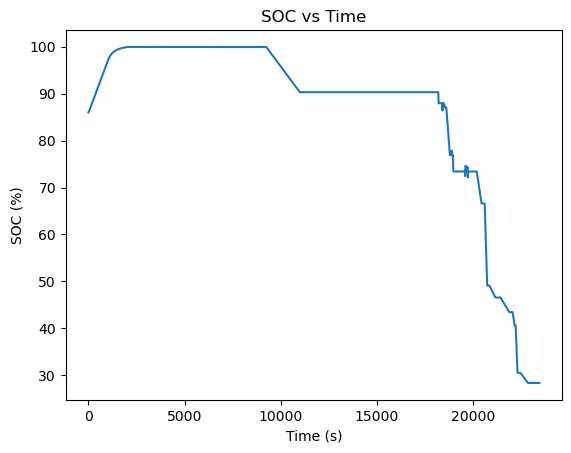

In [92]:
Z = np.ndarray(df_test.shape[0]) 
Z[0] = 0.86 # Starting SOC

df_test.loc[0,"Current"] = 0 # starting current appear sto be nan
for k in range(len(df_test.Time)-1) :
    Z[k+1] = Z[k]+ df_test.Current[k]*(1/2.500)/3600
    # Note cell capacity is 2.5 Ah
    # So we simply add/subtract the percentage of cell capacity we draw/add at each time step 

Z = Z*100

plt.plot(df_test.Time,Z)
plt.xlabel("Time (s)")
plt.ylabel("SOC (%)")
plt.title("SOC vs Time")
plt.show()

Calculate OCV by interpolating from the OCV Dataset using our Z values

In [93]:
Z = np.round(Z,2) # round to 2 decimal places
# drop duplicates so interpolation works
df_ocv = df_soc.drop_duplicates(subset=['SOC']) 
# interpolate
ocv_interpolation = interp1d(df_soc['SOC'], df_soc['OCV'], kind='cubic')
ocv = ocv_interpolation(Z)

Predict Voltage

In [94]:
R = 0.08/5 # Found by reading off the discharge characteristics graph in the data sheet
Voltpredict =  ocv + R*df_test.Current 

Plot Results

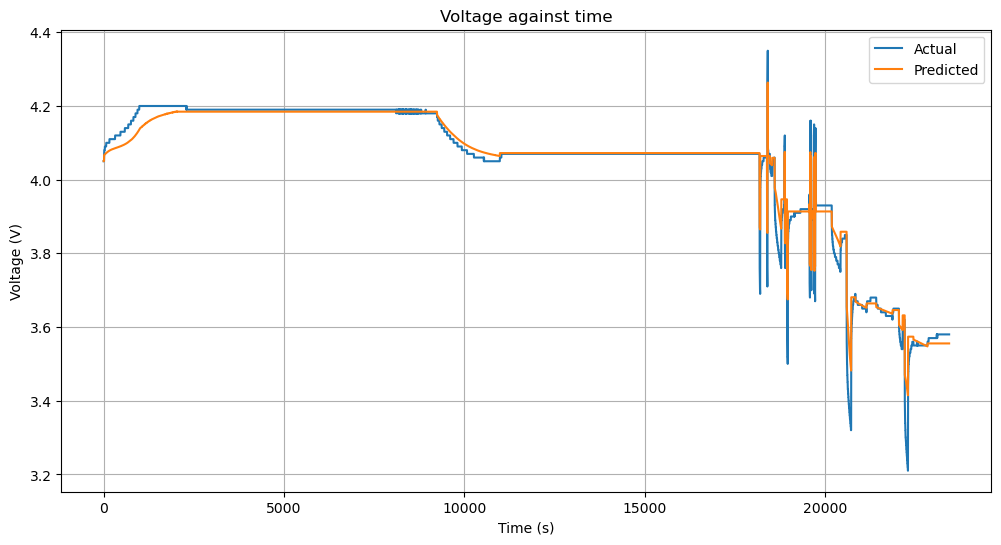

In [103]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df_test.Time,df_test.Voltage, label="Actual")
plt.plot(df_test.Time,Voltpredict, label="Predicted")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Voltage against time")
plt.show()


Plot errors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


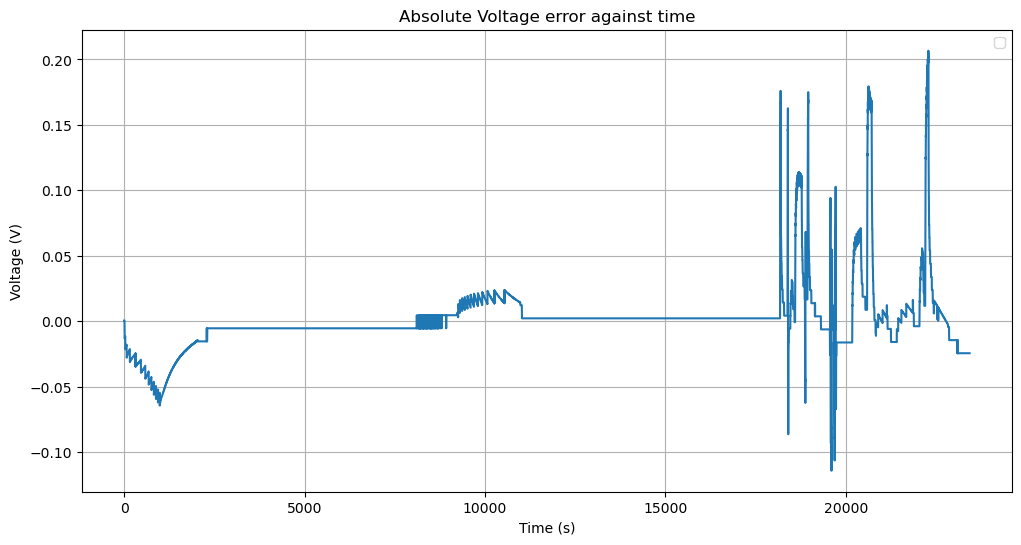

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


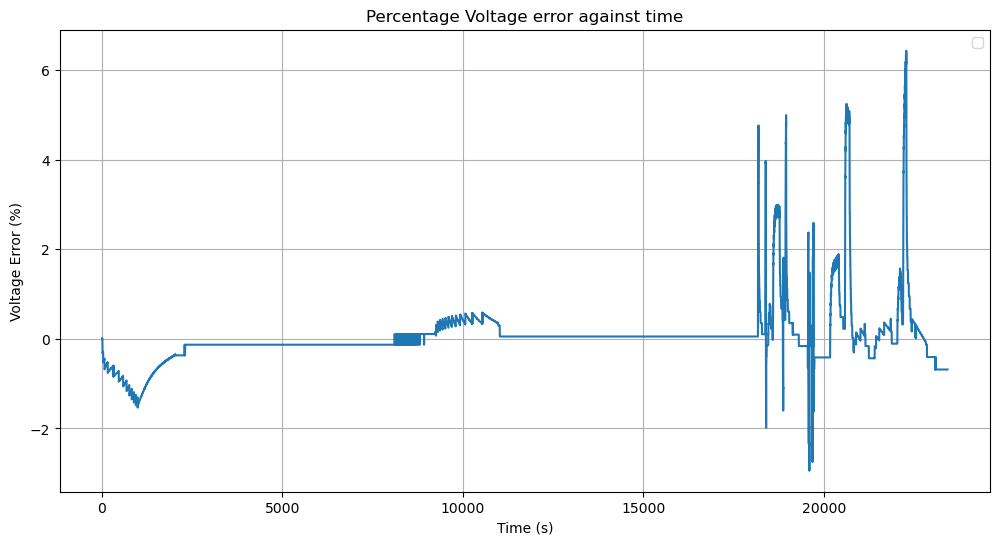

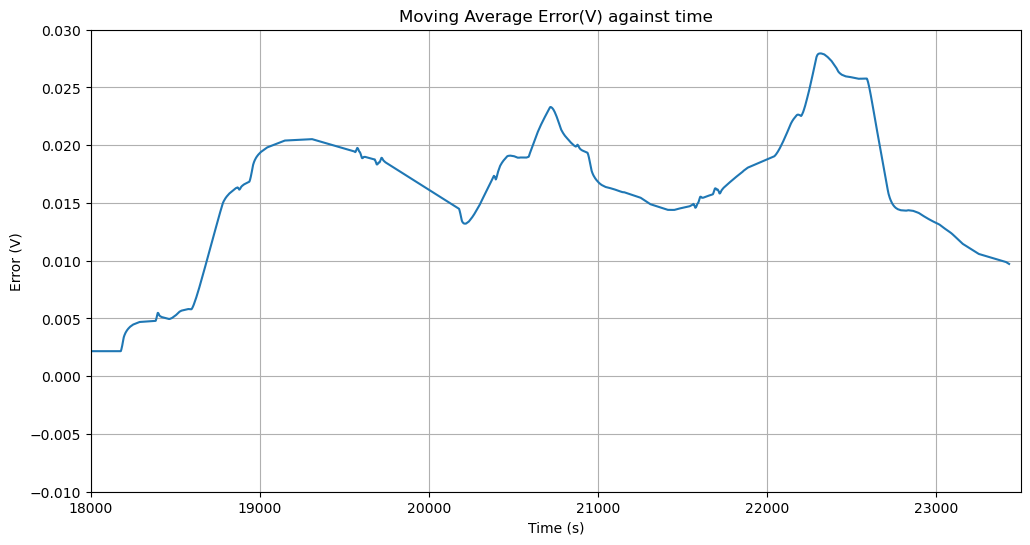

In [104]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df_test.Time,Voltpredict - df_test.Voltage)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Absolute Voltage error against time")
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df_test.Time,(Voltpredict - df_test.Voltage)/df_test.Voltage*100)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Voltage Error (%)")
plt.title("Percentage Voltage error against time")
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
#moving average
#for every 10 time steps we calculate the average
af = pd.DataFrame({"error": Voltpredict - df_test.Voltage, "time": df_test.Time})
af['Rolling_avg'] = af['error'].rolling(window=2000).mean()
plt.plot(af['time'], af['Rolling_avg'])
plt.xlabel("Time (s)")
plt.ylabel("Error (V)")
plt.title("Moving Average Error(V) against time")
plt.xlim(18000,23500)
plt.ylim(-0.01,0.03)
plt.grid()
plt.show()

Discussion

When the current suddenly changes by a large amount, the real cell voltage drops sharply. The predicted
voltage does not drop by nearly as much , giving rise to large errors. Afterwards, when the current
changes quickly from this large negative value to zero, the predicted voltage initially overshoots the actual
voltage . Though after a small period, they converge to a similar value.

The model, on the whole, struggles to capture the transient behaviour of the cell since it has no capacitance
and no variable resistances. Also, as our model relies on discrete time steps, when the current changes from
a value of 0 to a value of X, the model assumes that the current has been X in the whole of the preceding
time step (in this case, 1 second). So, if the real battery started experiencing a 20A current at, say, t=3.5s, our
model would assume it started experiencing this at t=3s.


The errors get larger as time increases. This is especially evident with the increasing peaks of the largest
errors.  Moving average
smoothens out the curve and allows trends to be more clearly seen.



The Thevenin model used is a very simple model that struggles to capture the complexity introduced by
near-instantaneous changes in the current, as well as the time step. Using only a single resistor, the
relationship between current and voltage is linear. This resistance is also constant, whereas in reality we
would expect some change in cell resistances from varying temperatures, SOCs, and currents. Introducing
non-linear components such as capacitors and having multiple non-constant resistors would allow more
complexity to be captured and improve the accuracy of the prediction.